In [134]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from ufs2arco import Layers2Pressure
from graphufs.lineplot import LinePlotter

In [2]:
lp = Layers2Pressure()

In [3]:
import graphufs
plt.style.use("graphufs.plotstyle")

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [4]:
import functools

In [135]:
xx = xr.open_zarr("/p1-evaluation/v1/validation/replay.240h.postprocessed.zarr")

In [5]:
def swap_dims(open_dataset):

    @functools.wraps(open_dataset)
    def wrapper(*args, **kwargs):
        xds = open_dataset(*args, **kwargs)
        if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
            xds = xds.rename({"prediction_timedelta": "lead_time"})
            

        if "lead_time" in xds:
            xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
            xds = xds.swap_dims({"lead_time": "fhr"})
        return xds
    return wrapper

In [6]:
@swap_dims
def open_zarr(*args, **kwargs):
    return xr.open_zarr(*args, **kwargs)
@swap_dims
def open_dataset(*args, **kwargs):
    return xr.open_dataset(*args, **kwargs)

In [17]:
LinePlotter.plot_levels?

Signature:
LinePlotter.plot_levels(
    self,
    dsdict: dict,
    truth: str,
    metric: str = 'mae',
    fields: tuple[str] = ('temperature', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind'),
    levels: tuple[int] = (100, 500, 850),
)
Docstring: <no docstring>
File:      /contrib2/Tim.Smith/graph-ufs/graphufs/lineplot.py
Type:      function

## Error in layer thickness: prognostic vs diagnostic

In [7]:
gds = open_dataset("/p1-evaluation/v1/validation/graphufs_vs_replay_240h_deterministic.nc")
dgds = open_dataset("/p1-evaluation/v1/validation/graphufs_vs_replay_240h_diagdelz_deterministic.nc")
drds = open_dataset("/p1-evaluation/v1/validation/replay_vs_replay_240h_diagdelz_deterministic.nc")

In [ ]:
levels = [100, 500, 850]
ncols = len(levels)
fig, axs = plt.subplots(1, ncols, figsize=(3*ncols, 4), constrained_layout=True)

for level, ax in zip(levels, axs):
    sps = ax.get_subplotspec()
    for j, (label, xds) in enumerate(zip(
        ["GraphUFS", "GraphUFS Diagnosed", "Replay Diagnosed"],
        [gds, dgds, drds],
    )):
        plotme = xds["layer_thickness"].sel(level=level, method="nearest")
        plotme = plotme.sel(metric="mae")
        plotme.plot(
            ax=ax,
            color=f"C{j*5}" if "Replay" not in label else "gray",
            label=label if sps.is_first_col() else None,
        )

    xticks = xds.fhr.values[3::4]
    
    ax.set(
        ylabel="",
        xlabel="Lead Time (days)",
        title=f"Native Level ~{level} hPa",
        xticks=xticks,
        xticklabels=[x // 24 for x in xticks],
    )

    fig.suptitle(f"Layer Thickness MAE vs Replay")
    fig.legend(loc="center left", bbox_to_anchor=(1, .5))

fig.savefig(f"figures/diagnosed_vs_predicted_delz.jpeg", bbox_inches="tight", dpi=300)

## Scratch geopotential calculation

In [65]:
gds = xr.open_zarr("/p1-evaluation/v1/validation/graphufs.240h.zarr")
gds = gds.isel(time=slice(20))

In [66]:
rds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.zarr",
    storage_options={"anon": True},
)
rds = rds.rename({"pfull": "level", "grid_xt": "lon", "grid_yt": "lat"})

In [67]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr",
    storage_options={"token": "anon"},
)
era = era.sel(
    level=[100,500,850],
)

In [68]:
era.geopotential

<xarray.DataArray 'geopotential' (time: 561264, level: 3, latitude: 721,
                                  longitude: 1440)> Size: 7TB
dask.array<getitem, shape=(561264, 3, 721, 1440), dtype=float32, chunksize=(1, 3, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) int64 24B 100 500 850
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 4MB 1959-01-01 ... 2023-01-10T23:00:00
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [69]:
rds = rds.isel(time=slice(10))

In [70]:
rds

<xarray.Dataset> Size: 6GB
Dimensions:        (time: 10, lat: 192, lon: 384, level: 127)
Coordinates:
    cftime         (time) object 80B dask.array<chunksize=(10,), meta=np.ndarray>
    ftime          (time) timedelta64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * lon            (lon) float64 3kB 0.0 0.9375 1.875 ... 357.2 358.1 359.1
  * lat            (lat) float64 2kB 89.82 88.89 87.95 ... -87.25 -88.18 -89.12
  * level          (level) float32 508B 0.01278 0.02033 0.03177 ... 996.2 998.8
  * time           (time) datetime64[ns] 80B 1993-12-31T18:00:00 ... 1994-01-...
Data variables: (12/179)
    acond          (time, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    albdo_ave      (time, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alnsf          (time, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alnwf          (time, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alvsf          (time, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alvwf          (time, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    ...             ...
    xtts           (time, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xu             (time, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xv             (time, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xz             (time, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xzts           (time, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    zc             (time, lat, lon) float32 3MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>

In [71]:
era = era.sel(time=rds.time)

In [255]:
def calc_hydrostatic_geopotential(hgtsfc, pressfc, delz, temp, spfh):
    """Note delz has to have vertical coordinate named level not pfull"""

    # a coordinate helper
    kp1_left = xr.DataArray(
        np.arange(len(lp.level)),
        coords={"level": lp.level.values},
    )
    kp1_right = xr.DataArray(
        np.arange(1, len(lp.level)+1),
        coords={"level": lp.level.values},
    )

    # Compute geopotential at interfaces, purely as a function of
    # surface pressure and surface height (and the static vertical coordinates)
    # Get pressure thickness
    prsi = lp.calc_pressure_interfaces(pressfc)
    dpres = lp.calc_pressure_thickness(prsi)
    dlogp = lp.calc_dlogp(prsi)

    spfh_thresh = spfh.where(spfh > lp.q_min, lp.q_min)
    rTv = lp.Rd * temp * (1. + lp.z_vir * spfh_thresh)

    rtvdlogp = rTv * dlogp
    rtvdlogp["kp1"] = kp1_left
    rtvdlogp = rtvdlogp.swap_dims({"level": "kp1"})
    dpres = dpres.swap_dims({"level": "kp1"}).drop_vars("level")

    # Geopotential at the surface
    phi0 = lp.g * hgtsfc
    phi0 = phi0.expand_dims({"kp1": [len(lp.level)]})

    # Concatenate, cumulative sum from the ground to TOA
    phii = xr.concat([dpres,phi0], dim="kp1")
    
    phii = phii.sortby("kp1", ascending=False)
    phii = phii.cumsum("kp1")
    phii = phii.sortby("kp1", ascending=True)

    phii = phii.


    # At last, geopotential is interfacial value + .5 * layer thickness * gravity
    geopotential = phii + 0.5 * lp.g * dz
    geopotential = geopotential.swap_dims({"kp1": "level"}).drop_vars("kp1")
    geopotential = geopotential.transpose(..., "level", "lat", "lon")
    return geopotential

In [75]:
prsi = lp.calc_pressure_interfaces(rds.pressfc.isel(time=0))
dlogp = lp.calc_dlogp(prsi)

In [77]:
dlogp

<xarray.DataArray (level: 127, lat: 192, lon: 384)> Size: 37MB
dask.array<sub, shape=(127, 192, 384), dtype=float32, chunksize=(127, 192, 384), chunktype=numpy.ndarray>
Coordinates:
    cftime   object 8B dask.array<chunksize=(), meta=np.ndarray>
    ftime    timedelta64[ns] 8B dask.array<chunksize=(), meta=np.ndarray>
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat      (lat) float64 2kB 89.82 88.89 87.95 87.01 ... -87.25 -88.18 -89.12
    time     datetime64[ns] 8B 1993-12-31T18:00:00
  * level    (level) float64 1kB 0.01278 0.02033 0.03177 ... 993.5 996.2 998.8

In [113]:
def calc_geopotential(hgtsfc, pressfc, delz):
    """Note delz has to have vertical coordinate named level not pfull"""

    # a coordinate helper
    kp1_left = xr.DataArray(
        np.arange(len(lp.level)),
        coords={"level": lp.level.values},
    )
    kp1_right = xr.DataArray(
        np.arange(1, len(lp.level)+1),
        coords={"level": lp.level.values},
    )

    # Geopotential at the surface
    phi0 = lp.g * hgtsfc
    phi0 = phi0.expand_dims({"kp1": [len(lp.level)]})

    # Concatenate, cumulative sum from the ground to TOA
    dz = lp.g*np.abs(delz)
    dz["kp1"] = kp1_left.sel(level=delz["level"])
    dz = dz.swap_dims({"level": "kp1"}).drop_vars("level")
    
    phii = xr.concat([dz,phi0], dim="kp1")
    
    phii = phii.sortby("kp1", ascending=False)
    phii = phii.cumsum("kp1")
    phii = phii.sortby("kp1", ascending=True)

    # At last, geopotential is interfacial value + .5 * layer thickness * gravity
    geopotential = phii - 0.5 * dz
    geopotential = geopotential.swap_dims({"kp1": "level"}).drop_vars("kp1")
    geopotential = geopotential.transpose(..., "level", "lat", "lon")
    geopotential.attrs["units"] = "m^2 / s^2"
    return geopotential, phii

In [114]:
hgtsfc = rds.hgtsfc.isel(time=0).drop_vars(["time", "cftime", "ftime"])

In [133]:
era.geopotential.dims

('time', 'level', 'latitude', 'longitude')

In [129]:
rds.geopotential

<xarray.DataArray 'geopotential' (time: 10, level: 127, lat: 192, lon: 384)> Size: 375MB
dask.array<sub, shape=(10, 127, 192, 384), dtype=float32, chunksize=(1, 127, 192, 384), chunktype=numpy.ndarray>
Coordinates:
    cftime   (time) object 80B dask.array<chunksize=(10,), meta=np.ndarray>
    ftime    (time) timedelta64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat      (lat) float64 2kB 89.82 88.89 87.95 87.01 ... -87.25 -88.18 -89.12
  * level    (level) float32 508B 0.01278 0.02033 0.03177 ... 993.5 996.2 998.8
  * time     (time) datetime64[ns] 80B 1993-12-31T18:00:00 ... 1994-01-01T21:...
Attributes:
    units:    m^2 / s^2

In [116]:
#gds["geopotential"] = calc_geopotential(
#    hgtsfc,
#    gds["pressfc"],
#    gds["delz"],
#)

In [115]:
rds["geopotential"], phii = calc_geopotential(
    hgtsfc,
    rds["pressfc"],
    rds["delz"],
)

In [118]:
phil = xr.DataArray(
    .5*(phii.values[:,:-1,...] + phii.values[:,1:,...]),
    coords={"time":rds.time.values, "level": rds.level.values, "lat": rds.lat.values, "lon": rds.lon.values},
)

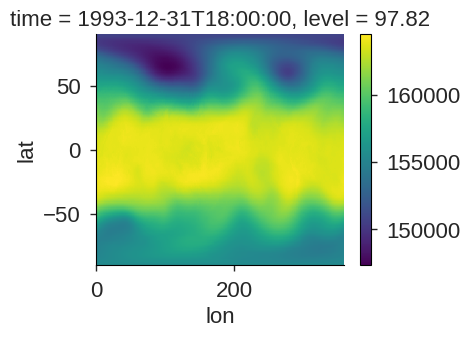

In [119]:
phil.isel(time=0).sel(level=100, method="nearest").plot()

In [122]:
expected = era.geopotential.sel(level=100)

In [123]:
test1 = phil.sel(level=100, method="nearest")
test2 = rds.geopotential.sel(level=100, method="nearest")

[[Text(0.5, 1.0, '')],
 [Text(0.5, 1.0, '')],
 [Text(0.5, 1.0, '')],
 [Text(0.5, 1.0, '')]]

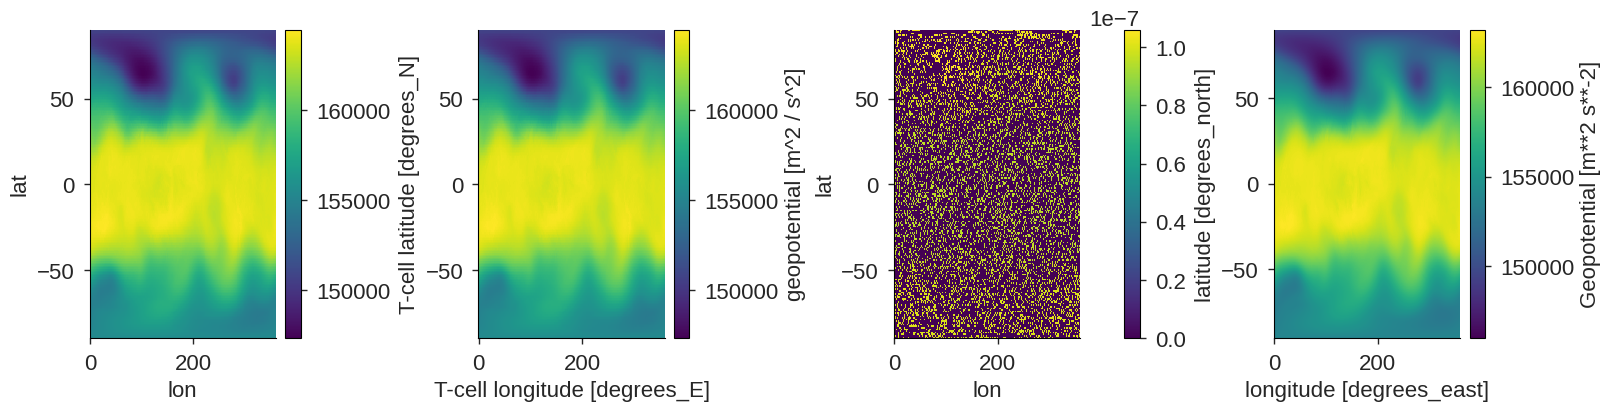

In [128]:
fig, axs = plt.subplots(1,4,figsize=(16, 4), constrained_layout=True)

itime = 0
test1.isel(time=itime).plot(ax=axs[0])
test2.isel(time=itime).plot(ax=axs[1])
(np.abs(test1-test2)/np.abs(test2)).isel(time=itime).plot(ax=axs[2])
expected.isel(time=itime).plot(ax=axs[3])
[ax.set(title="") for ax in axs]

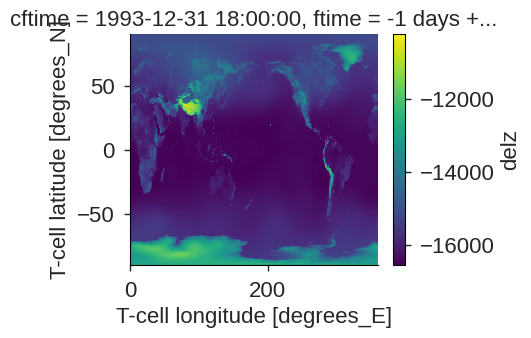

In [112]:
rds.delz.isel(time=0).sel(level=slice(100, 1000)).sum("level").plot()

## Compute a separate derived delz and geopotential dataset

In [7]:
import dask
dask.config.set(scheduler="threads", n_workers=48)

In [19]:
gds = xr.open_zarr("/p1-evaluation/v1/validation/graphufs.240h.zarr")
gds = gds.isel(time=slice(10))
rds = xr.open_zarr("/p1-evaluation/v1/validation/replay.240h.zarr")
rrds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.zarr",
    storage_options={"anon": True},
)
rds = rds.isel(time=slice(10))
print(gds)

<xarray.Dataset> Size: 10GB
Dimensions:     (time: 10, lead_time: 40, level: 13, lat: 192, lon: 384)
Coordinates:
  * lat         (lat) float64 2kB 89.82 88.89 87.95 ... -87.25 -88.18 -89.12
  * lead_time   (lead_time) timedelta64[ns] 320B 0 days 06:00:00 ... 10 days ...
  * level       (level) float32 52B 47.81 97.82 145.7 ... 847.8 921.9 998.8
  * lon         (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * time        (time) datetime64[ns] 80B 2022-01-01T03:00:00 ... 2022-01-11T...
Data variables:
    delz        (time, lead_time, level, lat, lon) float32 2GB dask.array<chunksize=(1, 40, 13, 192, 384), meta=np.ndarray>
    dzdt        (time, lead_time, level, lat, lon) float32 2GB dask.array<chunksize=(1, 40, 13, 192, 384), meta=np.ndarray>
    prateb_ave  (time, lead_time, lat, lon) float32 118MB dask.array<chunksize=(1, 40, 192, 384), meta=np.ndarray>
    pressfc     (time, lead_time, lat, lon) float32 118MB dask.array<chunksize=(1, 40, 192, 384), meta=np.ndarray

In [20]:
hgtsfc = rrds["hgtsfc"].isel(time=0).drop_vars(["time", "cftime", "ftime"])
hgtsfc = hgtsfc.rename({"grid_xt": "lon", "grid_yt":"lat"})
hgtsfc = hgtsfc.load()
hgtsfc

<xarray.DataArray 'hgtsfc' (lat: 192, lon: 384)> Size: 295kB
array([[   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [2594.6946, 2603.4043, 2612.1873, ..., 2571.3345, 2577.4958,
        2586.0544],
       [2645.6694, 2650.061 , 2654.4854, ..., 2632.703 , 2636.9885,
        2641.3113],
       [2709.6648, 2711.8574, 2714.0798, ..., 2704.064 , 2705.595 ,
        2707.5017]], dtype=float32)
Coordinates:
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat      (lat) float64 2kB 89.82 88.89 87.95 87.01 ... -87.25 -88.18 -89.12
Attributes:
    cell_methods:  time: point
    long_name:     surface geopotential height
    output_file:   dyn
    units:         m

In [21]:
gds = gds.drop_vars("delz")
gds["delz"] = lp.calc_delz(gds["pressfc"], gds["tmp"], gds["spfh"])
gds["delz"] = gds["delz"].compute()
gds["geopotential"] = lp.calc_geopotential(hgtsfc, delz=gds["delz"])
gds = gds.drop_vars(list(k for k in gds.data_vars if k not in ("delz", "geopotential", "tmp", "pressfc", "spfh")))

In [22]:
gds

<xarray.Dataset> Size: 6GB
Dimensions:       (lat: 192, lead_time: 40, level: 13, lon: 384, time: 10)
Coordinates:
  * lat           (lat) float64 2kB 89.82 88.89 87.95 ... -87.25 -88.18 -89.12
  * lead_time     (lead_time) timedelta64[ns] 320B 0 days 06:00:00 ... 10 day...
  * level         (level) float32 52B 47.81 97.82 145.7 ... 847.8 921.9 998.8
  * lon           (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * time          (time) datetime64[ns] 80B 2022-01-01T03:00:00 ... 2022-01-1...
Data variables:
    pressfc       (time, lead_time, lat, lon) float32 118MB dask.array<chunksize=(1, 40, 192, 384), meta=np.ndarray>
    spfh          (time, lead_time, level, lat, lon) float32 2GB dask.array<chunksize=(1, 40, 13, 192, 384), meta=np.ndarray>
    tmp           (time, lead_time, level, lat, lon) float32 2GB dask.array<chunksize=(1, 40, 13, 192, 384), meta=np.ndarray>
    delz          (time, lead_time, level, lat, lon) float32 2GB -527.0 ... -...
    geopotential  (time, lead_time, level, lat, lon) float32 2GB 3.504e+04 .....

In [23]:
gds.to_zarr("/p1-evaluation/v1/validation/graphufs.240h.diagnosed.zarr")

In [24]:
rds = rds.drop_vars("delz")
rds["delz"] = lp.calc_delz(rds["pressfc"], rds["tmp"], rds["spfh"])
rds["delz"] = rds["delz"].compute()
rds["geopotential"] = lp.calc_geopotential(hgtsfc, delz=rds["delz"])
rds = rds.drop_vars(list(k for k in rds.data_vars if k not in ("delz", "geopotential", "tmp", "pressfc", "spfh")))

In [25]:
rds

<xarray.Dataset> Size: 6GB
Dimensions:       (lat: 192, lead_time: 40, level: 13, lon: 384, time: 10)
Coordinates:
  * lat           (lat) float64 2kB 89.82 88.89 87.95 ... -87.25 -88.18 -89.12
  * lead_time     (lead_time) timedelta64[ns] 320B 0 days 06:00:00 ... 10 day...
  * level         (level) float32 52B 47.81 97.82 145.7 ... 847.8 921.9 998.8
  * lon           (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * time          (time) datetime64[ns] 80B 2022-01-01T03:00:00 ... 2022-01-1...
Data variables:
    pressfc       (time, lead_time, lat, lon) float32 118MB dask.array<chunksize=(1, 40, 192, 384), meta=np.ndarray>
    spfh          (time, lead_time, level, lat, lon) float32 2GB dask.array<chunksize=(1, 40, 13, 192, 384), meta=np.ndarray>
    tmp           (time, lead_time, level, lat, lon) float32 2GB dask.array<chunksize=(1, 40, 13, 192, 384), meta=np.ndarray>
    delz          (time, lead_time, level, lat, lon) float32 2GB -525.9 ... -...
    geopotential  (time, lead_time, level, lat, lon) float32 2GB 3.498e+04 .....

In [26]:
rds.to_zarr("/p1-evaluation/v1/validation/replay.240h.diagnosed.zarr")

## Scratch delz comparison

In [ ]:
gds = xr.open_zarr("/p1-evaluation/v1/validation/graphufs.240h.zarr")
gds = gds.isel(time=slice(None, None, 15))
rds = xr.open_zarr("/p1-evaluation/v1/validation/replay.240h.zarr")
rds = rds.isel(time=slice(None, None, 15))
print(gds)

In [122]:
errors = open_dataset("/p1-evaluation/v1/validation/graphufs_vs_replay_240h_deterministic.nc")
spatial = open_dataset("/p1-evaluation/v1/validation/graphufs_vs_replay_240h_deterministic_spatial.nc")
spatial = spatial.rename({"latitude": "lat", "longitude": "lon"})

In [20]:
gds["delz_derived"] = lp.calc_delz(gds["pressfc"], gds["tmp"], gds["spfh"])

In [21]:
diff = gds.delz - gds.delz_derived

In [22]:
reldiff = np.abs(diff) / np.abs(rds.delz)

In [23]:
avg_reldiff = reldiff.mean(["lat", "lon", "time"])

In [24]:
%%time
avg_reldiff = avg_reldiff.compute()

CPU times: user 2min 49s, sys: 7min 31s, total: 10min 21s
Wall time: 1min 5s


In [25]:
%%time
max_reldiff = reldiff.max(["lat", "lon", "time"]).compute()

CPU times: user 3min 30s, sys: 12min, total: 15min 30s
Wall time: 54.8 s


In [33]:
errors["layer_thickness"].sel(metric="mae")

<xarray.DataArray 'layer_thickness' (fhr: 40, level: 6)> Size: 2kB
[240 values with dtype=float64]
Coordinates:
    lead_time  (fhr) timedelta64[ns] 320B 0 days 06:00:00 ... 10 days 00:00:00
  * level      (level) float32 24B 998.8 847.8 505.7 243.9 97.82 47.81
    metric     <U3 12B 'mae'
  * fhr        (fhr) int64 320B 6 12 18 24 30 36 42 ... 210 216 222 228 234 240

In [34]:
relerr = np.abs(diff).sel(level=errors.level) / errors["layer_thickness"].sel(metric="mae")

In [38]:
%%time
avg_relerr = relerr.mean(["lat", "lon", "time"]).compute()
max_relerr = relerr.max(["lat", "lon", "time"]).compute()

CPU times: user 6min 45s, sys: 23min 2s, total: 29min 47s
Wall time: 1min 45s


In [26]:
%%time
avg_absdiff = np.abs(diff).mean(["lat", "lon", "time"]).compute()
max_absdiff = np.abs(diff).max(["lat", "lon", "time"]).compute()

CPU times: user 6min 41s, sys: 22min 9s, total: 28min 50s
Wall time: 1min 41s


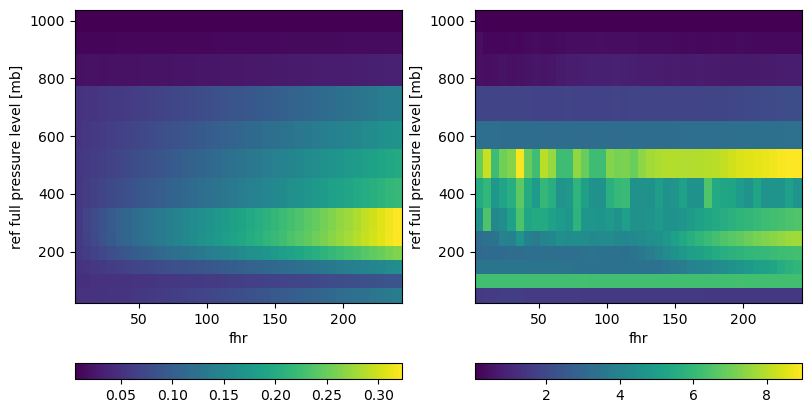

In [27]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
avg_absdiff.plot(x="fhr", ax=axs[0], cbar_kwargs={"orientation":"horizontal"})
max_absdiff.plot(x="fhr", ax=axs[1], cbar_kwargs={"orientation":"horizontal"})

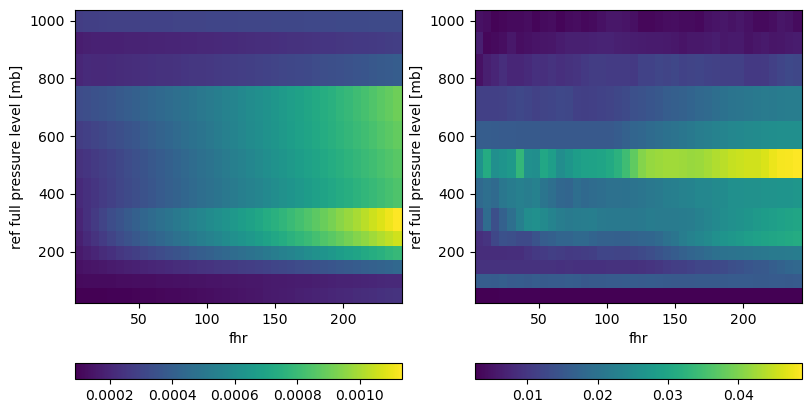

In [28]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
avg_reldiff.plot(x="fhr", ax=axs[0], cbar_kwargs={"orientation":"horizontal"})
max_reldiff.plot(x="fhr", ax=axs[1], cbar_kwargs={"orientation":"horizontal"})

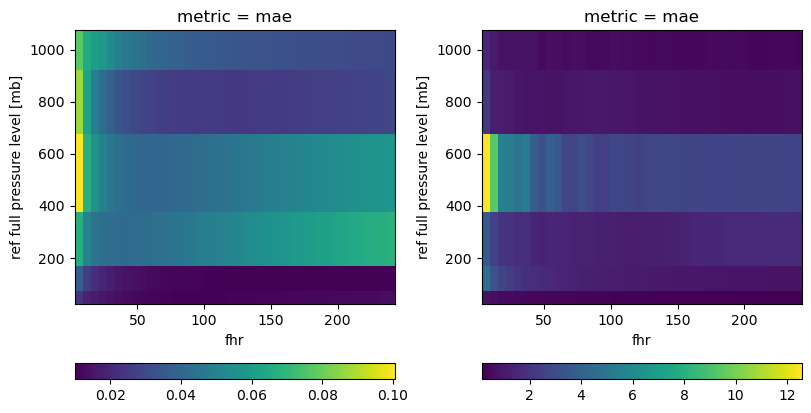

In [39]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
avg_relerr.plot(x="fhr", ax=axs[0], cbar_kwargs={"orientation":"horizontal"})
max_relerr.plot(x="fhr", ax=axs[1], cbar_kwargs={"orientation":"horizontal"})

### Derived 2m Temperature

In [95]:
dz_right = np.abs(gds.delz_derived.isel(level=-1))
dz_left = np.abs(gds.delz_derived.isel(level=-2))

In [96]:
z_b = dz_right / 2
z_bm1 = dz_right + dz_left/2

In [97]:
t_b = gds.tmp.isel(level=-1)
t_bm1 = gds.tmp.isel(level=-2)

In [98]:
t2m_d = (2 - z_b)/(z_bm1 - z_b) * (t_bm1 - t_b) + t_b

In [107]:
diff = (t2m_d - rds.tmp2m)
reldiff = ( np.abs(diff) / rds.tmp2m ).compute()

In [123]:
relerror = (np.abs(diff) / spatial["2m_temperature"].sel(metric="mae")).compute()

In [136]:
extrap = t2m_d - gds.tmp2m
reldiff_extrap = ( np.abs(extrap) / rds.tmp2m ).compute()
relerror_extrap = (np.abs(extrap) / spatial["2m_temperature"].sel(metric="mae")).compute()

[Text(0.5, 1.0, 't2m max_(IC, fhr) {\n|DerivedGraphUFS - Replay| /  (Replay)}')]

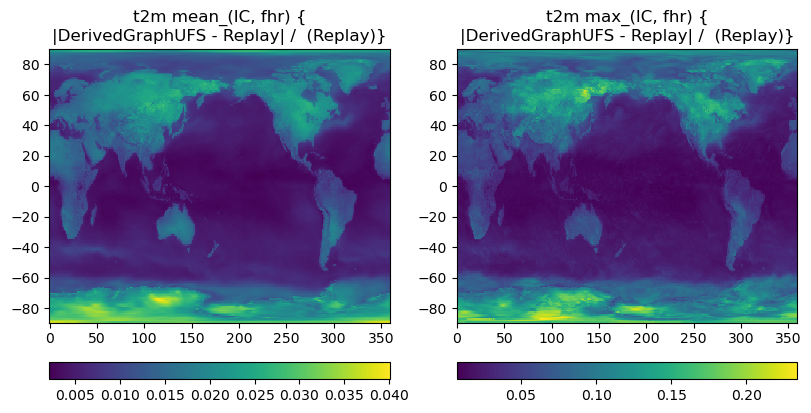

In [138]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
kw = {"cbar_kwargs": {"orientation":"horizontal"}}
reldiff.mean(["time", "fhr"]).plot(ax=axs[0], **kw)
reldiff.max(["time", "fhr"]).plot(ax=axs[1], **kw)
[ax.set(xlabel="", ylabel="") for ax in axs];
axs[0].set(title="t2m mean_(IC, fhr) {\n|DerivedGraphUFS - Replay| /  (Replay)}")
axs[1].set(title="t2m max_(IC, fhr) {\n|DerivedGraphUFS - Replay| /  (Replay)}")

[Text(0.5, 1.0, 't2m max_(IC, fhr) {\n|DerivedGraphUFS - Replay| / \n meanIC|GraphUFS - Replay|}')]

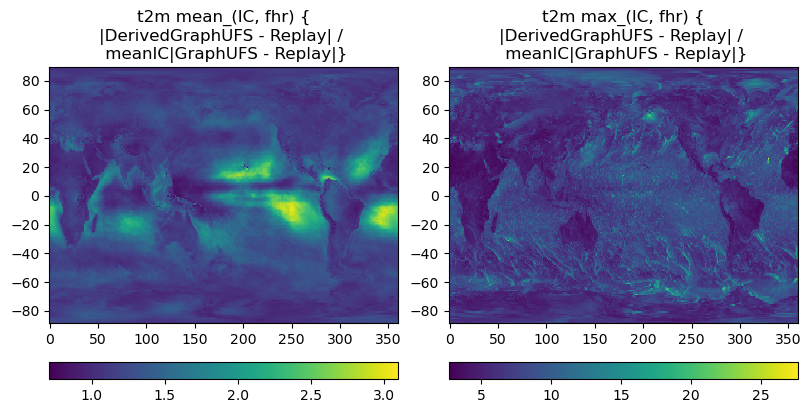

In [139]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
relerror.mean(["time", "fhr"]).plot(ax=axs[0], **kw)
relerror.max(["time", "fhr"]).plot(ax=axs[1], **kw)
[ax.set(xlabel="", ylabel="") for ax in axs];

axs[0].set(title="t2m mean_(IC, fhr) {\n|DerivedGraphUFS - Replay| / \n meanIC|GraphUFS - Replay|}")
axs[1].set(title="t2m max_(IC, fhr) {\n|DerivedGraphUFS - Replay| / \n meanIC|GraphUFS - Replay|}")

[Text(0.5, 1.0, 't2m max_(IC, fhr) {\n|DerivedGraphUFS - GraphUFS| /  (Replay)}')]

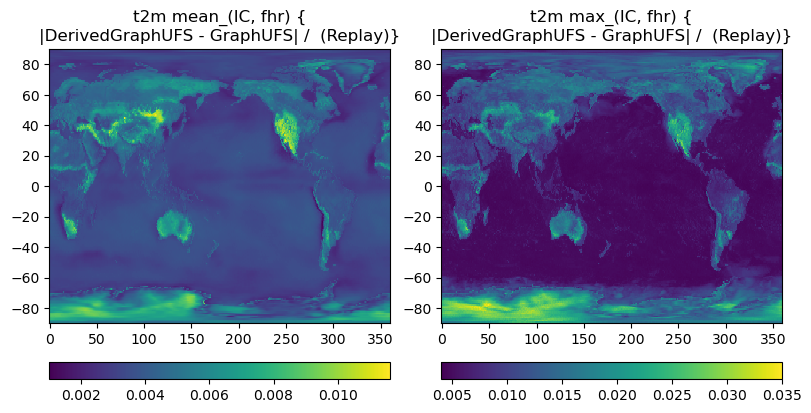

In [140]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
kw = {"cbar_kwargs": {"orientation":"horizontal"}}
reldiff_extrap.mean(["time", "fhr"]).plot(ax=axs[0], **kw)
reldiff_extrap.max(["time", "fhr"]).plot(ax=axs[1], **kw)
[ax.set(xlabel="", ylabel="") for ax in axs];
axs[0].set(title="t2m mean_(IC, fhr) {\n|DerivedGraphUFS - GraphUFS| /  (Replay)}")
axs[1].set(title="t2m max_(IC, fhr) {\n|DerivedGraphUFS - GraphUFS| /  (Replay)}")

[Text(0.5, 1.0, 't2m max_(IC, fhr) {\n|DerivedGraphUFS - GraphUFS| / \n meanIC|GraphUFS - Replay|}')]

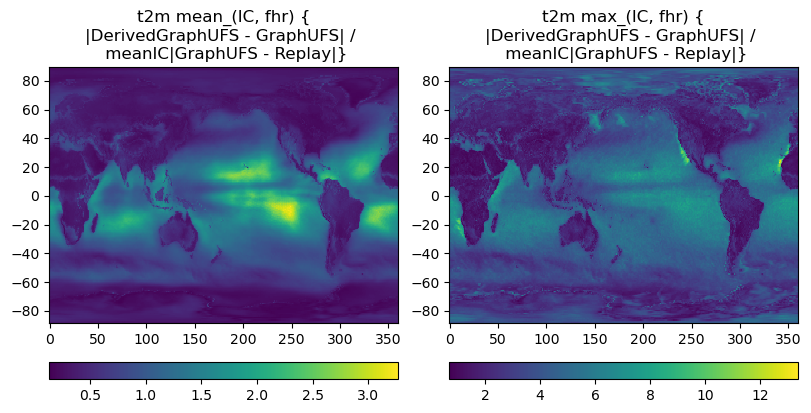

In [141]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
kw = {"cbar_kwargs": {"orientation":"horizontal"}}
relerror_extrap.mean(["time", "fhr"]).plot(ax=axs[0], **kw)
relerror_extrap.max(["time", "fhr"]).plot(ax=axs[1], **kw)
[ax.set(xlabel="", ylabel="") for ax in axs];
axs[0].set(title="t2m mean_(IC, fhr) {\n|DerivedGraphUFS - GraphUFS| / \n meanIC|GraphUFS - Replay|}")
axs[1].set(title="t2m max_(IC, fhr) {\n|DerivedGraphUFS - GraphUFS| / \n meanIC|GraphUFS - Replay|}")

[Text(0.5, 1.0, 't2m |DerivedGraphUFS - Replay| /  meanIC|GraphUFS - Replay|')]

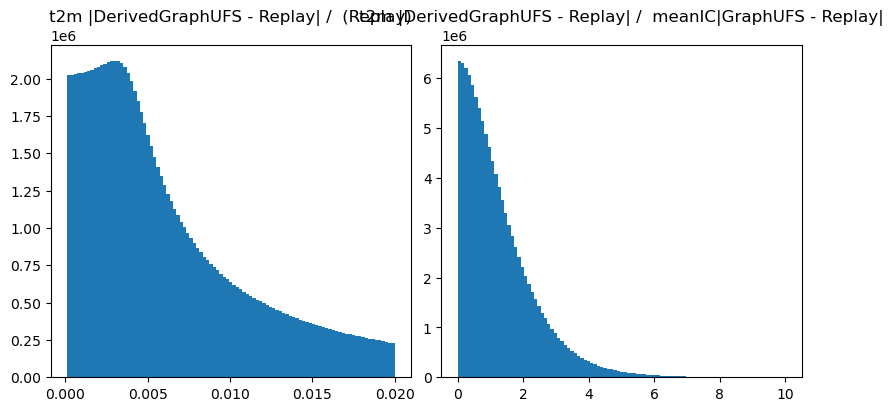

In [143]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
reldiff.plot(bins=np.linspace(0.0001, 0.02, 100), ax=axs[0])
relerror.plot(bins=np.linspace(0.0001, 10., 100), ax=axs[1]);
#axs[0].set(title="2m Temperature |Extrapolated in Replay - Actual| / |Actual|")

axs[0].set(title="t2m |DerivedGraphUFS - Replay| /  (Replay)")
axs[1].set(title="t2m |DerivedGraphUFS - Replay| /  meanIC|GraphUFS - Replay|")
#axs[1].set(title="2m Temperature |Extrapolated in Replay - Actual| / MAE(GraphUFS Prediction)")

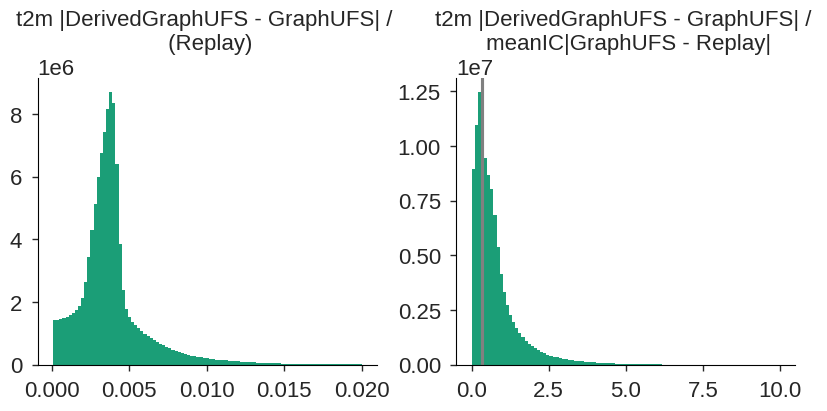

In [150]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
reldiff_extrap.plot(bins=np.linspace(0.0001, 0.02, 100), ax=axs[0])
relerror_extrap.plot(bins=np.linspace(0.0001, 10., 100), ax=axs[1]);
#axs[0].set(title="2m Temperature |Extrapolated in Replay - Actual| / |Actual|")

axs[0].set(title="t2m |DerivedGraphUFS - GraphUFS| / \n (Replay)")
axs[1].set(title="t2m |DerivedGraphUFS - GraphUFS| / \n meanIC|GraphUFS - Replay|")
axs[1].axvline(x=.35, color="gray")
#axs[1].set(title="2m Temperature |Extrapolated in Replay - Actual| / MAE(GraphUFS Prediction)")

Error in the extrapolation is <1% when considering value relative to predicted t2m, but is on average 1/2 the size of the prediction error in GraphUFS.

The situation does not really change whether delz is the predicted or diagnosed version.